In [ ]:
import pandas as pd 
import torch
from chronos import ChronosPipeline, ChronosBoltPipeline
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
pipeline = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cpu",  
    torch_dtype=torch.bfloat16,
)

In [3]:
context_length = pipeline.model.config.n_positions  # Key change here

print(f"Context window: {context_length} time steps")

Context window: 512 time steps


In [4]:
df = pd.read_csv('data/INTC_1H.csv')
price_columns = ['Open', 'High', 'Low', 'Close']
df[price_columns] = df[price_columns].round(2)
print(len(df))
print(df.head())
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head()

3488
                    Datetime   Open   High    Low  Close   Volume  Dividends  \
0  2023-03-27 14:30:00-04:00  29.52  29.60  29.39  29.42        0        0.0   
1  2023-03-27 15:30:00-04:00  29.41  29.42  29.15  29.21  6123103        0.0   
2  2023-03-28 09:30:00-04:00  29.08  29.14  28.75  28.80  6001110        0.0   
3  2023-03-28 10:30:00-04:00  28.80  29.19  28.63  29.11  5362455        0.0   
4  2023-03-28 11:30:00-04:00  29.11  29.23  28.96  28.99  3354148        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


C:\Users\micha\AppData\Local\Temp\ipykernel_31508\1311112096.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Datetime'] = pd.to_datetime(df['Datetime'])


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-03-27 14:30:00-04:00,29.52,29.60,29.39,29.42,0,0.0,0.0
1,2023-03-27 15:30:00-04:00,29.41,29.42,29.15,29.21,6123103,0.0,0.0
2,2023-03-28 09:30:00-04:00,29.08,29.14,28.75,28.80,6001110,0.0,0.0
3,2023-03-28 10:30:00-04:00,28.80,29.19,28.63,29.11,5362455,0.0,0.0
4,2023-03-28 11:30:00-04:00,29.11,29.23,28.96,28.99,3354148,0.0,0.0


In [6]:
input_df = df
input_df = pd.DataFrame({'unique_id':[1]*len(input_df),'ds': input_df["Datetime"], "y":input_df['Close']})
input_df

,unique_id,ds,y
0,1,2023-03-27 14:30:00-04:00,29.42
1,1,2023-03-27 15:30:00-04:00,29.21
2,1,2023-03-28 09:30:00-04:00,28.80
3,1,2023-03-28 10:30:00-04:00,29.11
4,1,2023-03-28 11:30:00-04:00,28.99
...,...,...,...
3483,1,2025-03-26 10:30:00-04:00,23.33
3484,1,2025-03-26 11:30:00-04:00,23.44
3485,1,2025-03-26 12:30:00-04:00,23.41
3486,1,2025-03-26 13:30:00-04:00,23.34


In [9]:
context_vrsta = torch.tensor(input_df['y'].values, dtype=torch.float32)
context_vrsta


tensor([29.4200, 29.2100, 28.8000,  ..., 23.4100, 23.3400, 23.3000])

In [10]:
prediction_length = 12*4 

def sliding_window_predictions(df, window_size=1024, step=24):
    predictions = []
    for i in range(window_size, len(df), step):
        context = torch.tensor(df['y'].values[i-window_size:i], dtype=torch.float32)
        quantiles, _ = pipeline.predict_quantiles(context, prediction_length=step)
        predictions.append(quantiles)
    return torch.cat(predictions, dim=1)



Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
C:\Users\micha\AppData\Local\Temp\ipykernel_31508\2805728019.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(


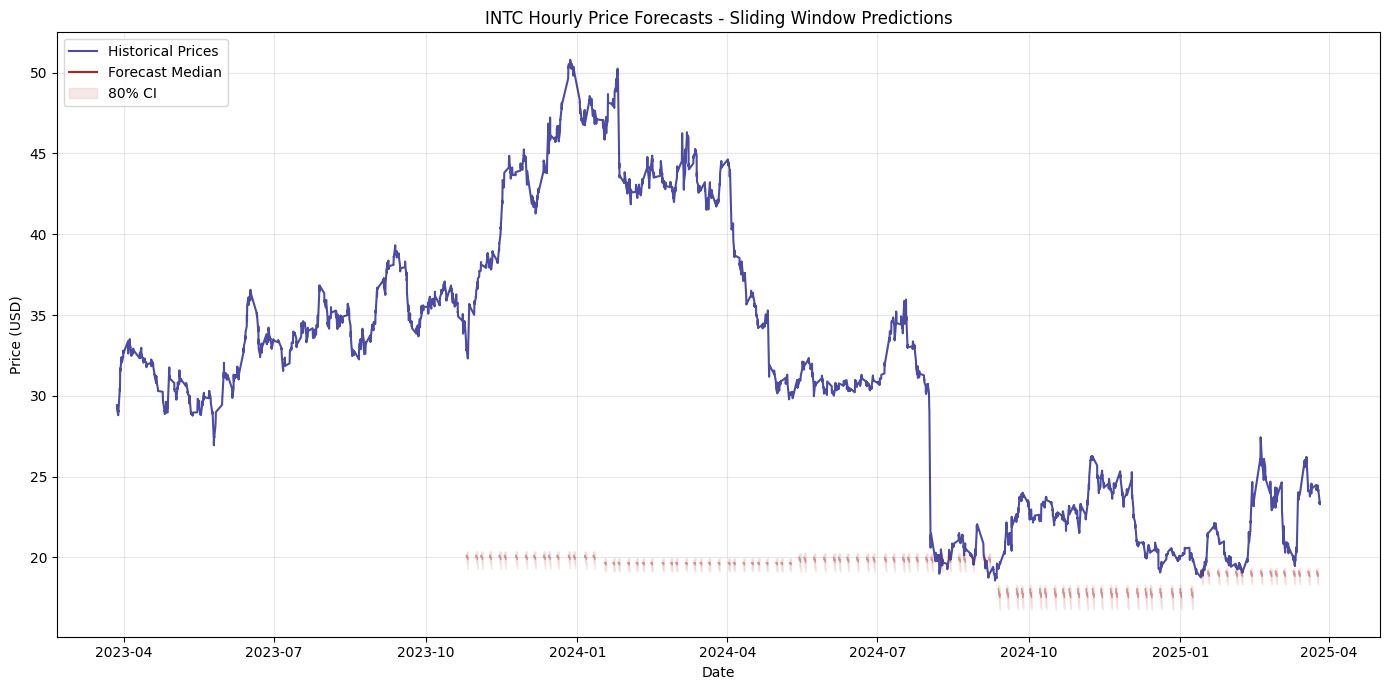

In [11]:
quantiles = sliding_window_predictions(input_df, window_size=1024, step=24)

# Prepare plot data
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(input_df['ds'], input_df['y'], color='navy', alpha=0.7, label='Historical Prices')

# Plot forecasts with correct timestamps
for i, idx in enumerate(range(1024, len(input_df), 24)):
    if i >= len(input_df):  # Handle edge case
        break
    
    # Get forecast start time (next timestamp after context window)
    start_time = input_df.iloc[idx]['ds'] + pd.Timedelta(hours=1)
    
    # Create forecast timestamps
    forecast_times = pd.date_range(
        start=start_time,
        periods=24,
        freq='H'
    )
    
    # Get corresponding quantiles
    start_q = (i - 1024) // 24 * 24
    end_q = start_q + 24
    window_quantiles = quantiles[0, start_q:end_q]
    
    # Plot this window's forecast
    plt.plot(forecast_times, window_quantiles[:, 1],  # Median
            color='firebrick', alpha=0.4, linewidth=1)
    plt.fill_between(forecast_times,
                    window_quantiles[:, 0],  # 10th percentile
                    window_quantiles[:, 2],  # 90th percentile
                    color='firebrick', alpha=0.1)

# Add final plot elements
plt.title('INTC Hourly Price Forecasts - Sliding Window Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(alpha=0.3)
plt.legend()

# Add a single representative forecast line for legend
plt.plot([], [], color='firebrick', label='Forecast Median')
plt.fill_between([], [], [], color='firebrick', alpha=0.1, label='80% CI')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()